# Image cleaning and atom finding using pycroscopy
### Suhas Somnath, Chris R. Smith, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
1/19/2017

## Configure the notebook first

In [1]:
# set up notebook to show plots within the notebook
% matplotlib inline

# Import necessary libraries:
# General utilities:
import os
import sys
from time import time
from scipy.misc import imsave

# Computation:
import numpy as np
import h5py
from skimage import measure
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist 

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import ImageGrid

# Finally, pycroscopy itself
import pycroscopy as px

## Load the image that will be cleaned:

In [2]:
#image_path = px.io.uiGetFile('*.png *PNG *TIFF * TIF *tif *tiff *BMP *bmp','Images')
image_path = "/Users/ba8/Dropbox (ORNL)/MLMR_2018/Feature_detection_2/image_cropped.png"

print('Working on: \n{}'.format(image_path))

folder_path, file_name = os.path.split(image_path)
base_name, _ = os.path.splitext(file_name)

Working on: 
/Users/ba8/Dropbox (ORNL)/MLMR_2018/Feature_detection_2/image_cropped.png


## Make the image file pycrscopy compatible
Convert the source image file into a pycroscopy compatible hierarchical data format (HDF or .h5) file. This simple translation gives you access to the powerful data functions within pycroscopy

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

In [3]:
# Check if an HDF5 file with the chosen image already exists.
# Only translate if it does not.
h5_path = os.path.join(folder_path, base_name+'.h5')
need_translation = True
if os.path.exists(h5_path):
    try:
        h5_file = h5py.File(h5_path, 'r+')
        h5_raw = h5_file['Measurement_000']['Channel_000']['Raw_Data']
        need_translation = False
        print('HDF5 file with Raw_Data found.  No need to translate.')
    except KeyError:
        print('Raw Data not found.')
else:
    print('No HDF5 file found.')

if need_translation:
    # Initialize the Image Translator
    tl = px.ImageTranslator()

    # create an H5 file that has the image information in it and get the reference to the dataset
    h5_raw = tl.translate(image_path)

    # create a reference to the file
    h5_file = h5_raw.file

print('HDF5 file is located at {}.'.format(h5_file.filename))

HDF5 file with Raw_Data found.  No need to translate.
HDF5 file is located at /Users/ba8/Dropbox (ORNL)/MLMR_2018/Feature_detection_2/image_cropped.h5.


### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a contemporary computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data.  
In the case of these 2D images, the data is stored as a N x 1 dataset

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.
In the case of the 2d images, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0....
The spectroscopic information is trivial since the data at any given pixel is just a scalar value

In [4]:
print('Datasets and datagroups within the file:')
px.io.hdf_utils.print_tree(h5_file)
 
print('\nThe main dataset:')
print(h5_file['/Measurement_000/Channel_000/Raw_Data'])
print('\nThe ancillary datasets:')
print(h5_file['/Measurement_000/Channel_000/Position_Indices'])
print(h5_file['/Measurement_000/Channel_000/Position_Values'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup')
for key in h5_file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, h5_file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-Windowing_000
Measurement_000/Channel_000/Raw_Data-Windowing_000/Image_Windows
Measurement_000/Channel_000/Raw_Data-Windowing_000/Position_Indices
Measurement_000/Channel_000/Raw_Data-Windowing_000/Position_Values
Measurement_000/Channel_000/Raw_Data-Windowing_000/Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-Windowing_000/Spectroscopic_Values
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values

The main dataset:
<HDF5 dataset "Raw_Data": shape (239604, 1), type "|u1">

The ancillary datasets:
<HDF5 dataset "Position_Indices": shape (239604, 2), type "<u4">
<HDF5 dataset "Position_Values": shape (239604, 2), type "<f4">
<HDF5 dataset "Spectroscopic_Indices": shape (1, 1), type "<u4

## Initialize an object that will perform image windowing on the .h5 file
* Note that after you run this, the H5 file is opened. If you want to re-run this cell, close the H5 file first

In [5]:
# Initialize the windowing class
iw = px.ImageWindow(h5_raw, max_RAM_mb=1024*4)

# grab position indices from the H5 file
h5_pos = h5_raw.parent[h5_raw.attrs['Position_Indices']]

# determine the image size:
num_x = len(np.unique(h5_pos[:,0]))
num_y = len(np.unique(h5_pos[:,1]))

# extract figure data and reshape to proper numpy array
raw_image_mat = np.reshape(h5_raw[()], [num_x,num_y]);

## Visualize the source image:
Though the source file is actually grayscale image, we will visualize it using a color-scale

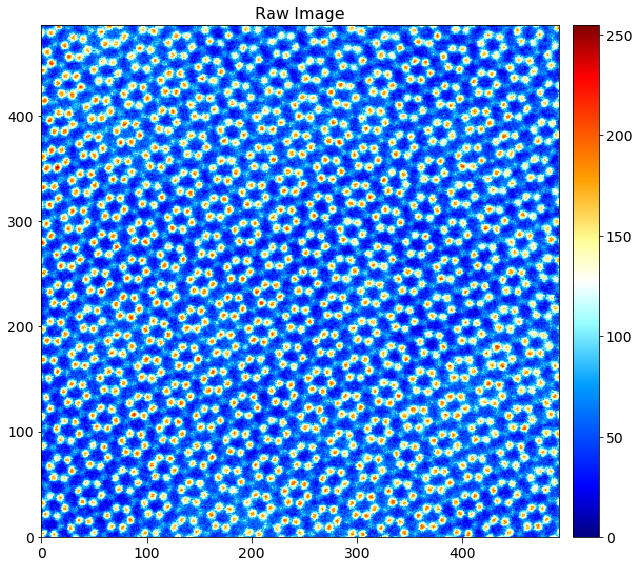

In [6]:
fig, axis = plt.subplots(figsize=(10,10))
img = axis.imshow(raw_image_mat,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower');
divider = make_axes_locatable(axis)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(img, cax=cax)
axis.set_title('Raw Image', fontsize=16);

## Extract the optimal window size from the image

Determining appropriate window size from image.


/Users/ba8/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


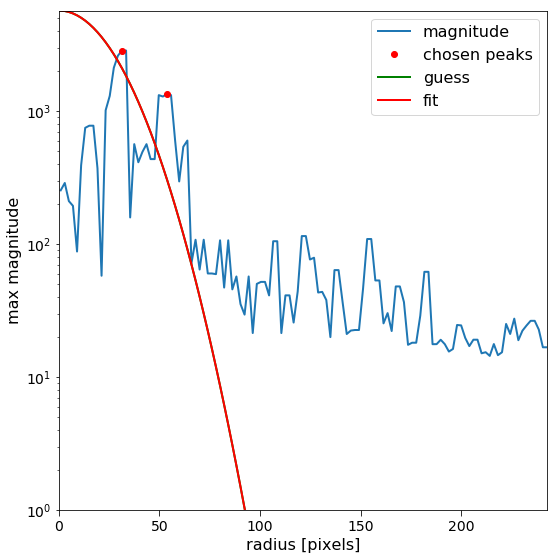

Window size = 30


In [7]:
num_peaks = 2
win_size , psf_width = iw.window_size_extract(num_peaks, save_plots=False, show_plots=True)

print('Window size = {}'.format(win_size))

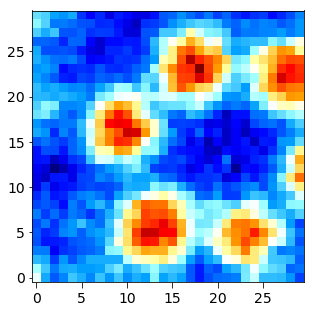

In [8]:
# Uncomment this line if you need to manually specify a window size
# win_size = 8

# plot a single window
row_offset = int(0.5*(num_x-win_size))
col_offset = int(0.5*(num_y-win_size))
plt.imshow(raw_image_mat[row_offset:row_offset+win_size,
                         col_offset:col_offset+win_size], 
           cmap=px.plot_utils.cmap_jet_white_center(),
          origin='lower');

# the result should be about the size of a unit cell
# if it is the wrong size, just choose on manually by setting the win_size

## Now break the image into a sequence of small windows
We do this by sliding a small window across the image. This artificially baloons the size of the data.

In [9]:
# Check if we need to do the windowing of if they already exist in the file.
need_windows = True
fft_mode = None # Options are None, 'abs', 'data+abs', or 'complex'
win_x = win_size
win_y = win_size
win_step_x = 1
win_step_y = 1
try:
    h5_wins = h5_raw.parent['Raw_Data-Windowing_000']['Image_Windows']
    tests = [h5_wins.parent.attrs['fft_mode']==fft_mode,
             h5_wins.parent.attrs['win_x']==win_x,
             h5_wins.parent.attrs['win_y']==win_y,
             h5_wins.parent.attrs['win_step_x']==win_step_x,
             h5_wins.parent.attrs['win_step_y']==win_step_y
            ]
    if all(tests):
        print("Windows already exist.")
        need_windows = False
    else:
        print("Windows exist, but were created using different parameters than those specified above.")
except KeyError:
    print('Windows not found.')
    pass
except:
    raise

# Do the windowing if needed
# this creates a 4D data set that associates each pixel with a window
if need_windows:
    t0 = time()
    h5_wins = iw.do_windowing(win_x=win_size,
                              win_y=win_size,
                              save_plots=False,
                              show_plots=False,
                              win_fft=fft_mode)
    print('Windowing took {} seconds.'.format(round(time()-t0, 2)))

print('\nRaw data was of shape {} and the windows dataset is now of shape {}'.format(h5_raw.shape, h5_wins.shape))
print('Now each position (window) is descibed by a set of pixels')

Windows exist, but were created using different parameters than those specified above.
Determining appropriate window size from image.
Optimal window size determined to be 30x30 pixels.
Windowing took 0.36 seconds.

Raw data was of shape (239604, 1) and the windows dataset is now of shape (212054, 900)
Now each position (window) is descibed by a set of pixels


## Performing Singular Value Decompostion (SVD) on the windowed data
SVD decomposes data (arranged as position x value) into a sequence of orthogonal components arranged in descending order of variance. The first component contains the most significant trend in the data. The second component contains the next most significant trend orthogonal to all previous components (just the first component). Each component consists of the trend itself (eigenvector), the spatial variaion of this trend (eigenvalues), and the variance (statistical importance) of the component.

Since the data consists of the large sequence of small windows, SVD essentially compares every single window with every other window to find statistically significant trends in the image

In [16]:
#Check if we need to do the SVD decomposition
need_svd = True
try:
    h5_svd = h5_wins.parent['Image_Windows-SVD_000']
    
    if num_comp==np.min(h5_wins.shape)*len(h5_wins.dtype):
        print( 'SVD Decomposition has already been done.')
        need_svd = False
    else:
        print( 'SVD Decomposition done, but with different number of components.  Will redo.')
except KeyError:
    print( "SVD Decomposition not found.")
except:
    raise

# Do SVD on all of the windows if needed
if need_svd:
    h5_svd_group = px.hdf_utils.findH5group(h5_main, 'SVD')

h5_U = h5_svd_group['U']
h5_V = h5_svd_group['V']
h5_S = h5_svd_group['S']

# extract parameters of the SVD results 
h5_pos = iw.hdf.file[h5_wins.attrs['Position_Indices']]
num_rows = len(np.unique(h5_pos[:, 0]))
num_cols = len(np.unique(h5_pos[:, 1]))

num_comp = h5_S.size

plot_comps = 49
U_map_stack = np.reshape(h5_U[:, :plot_comps], [num_rows, num_cols, -1])
V_map_stack = np.reshape(h5_V, [num_comp, win_size, win_size])
V_map_stack = np.transpose(V_map_stack,(2,1,0))

SVD Decomposition not found.


NameError: name 'h5_main' is not defined

## Visualize the SVD results

##### S (variance):
The plot below shows the variance or statistical significance of the SVD components. The first few components contain the most significant information while the last few components mainly contain noise. 

Note also that the plot below is a log-log plot. The importance of each subsequent component drops exponentially.

In [ ]:
# Visualizing the variance or importance of the components via a scree plot:
fig_S, ax_S = px.plot_utils.plotScree(h5_S[()]);

#### V (Eigenvectors)
The V dataset contains the eigenvectors for each component

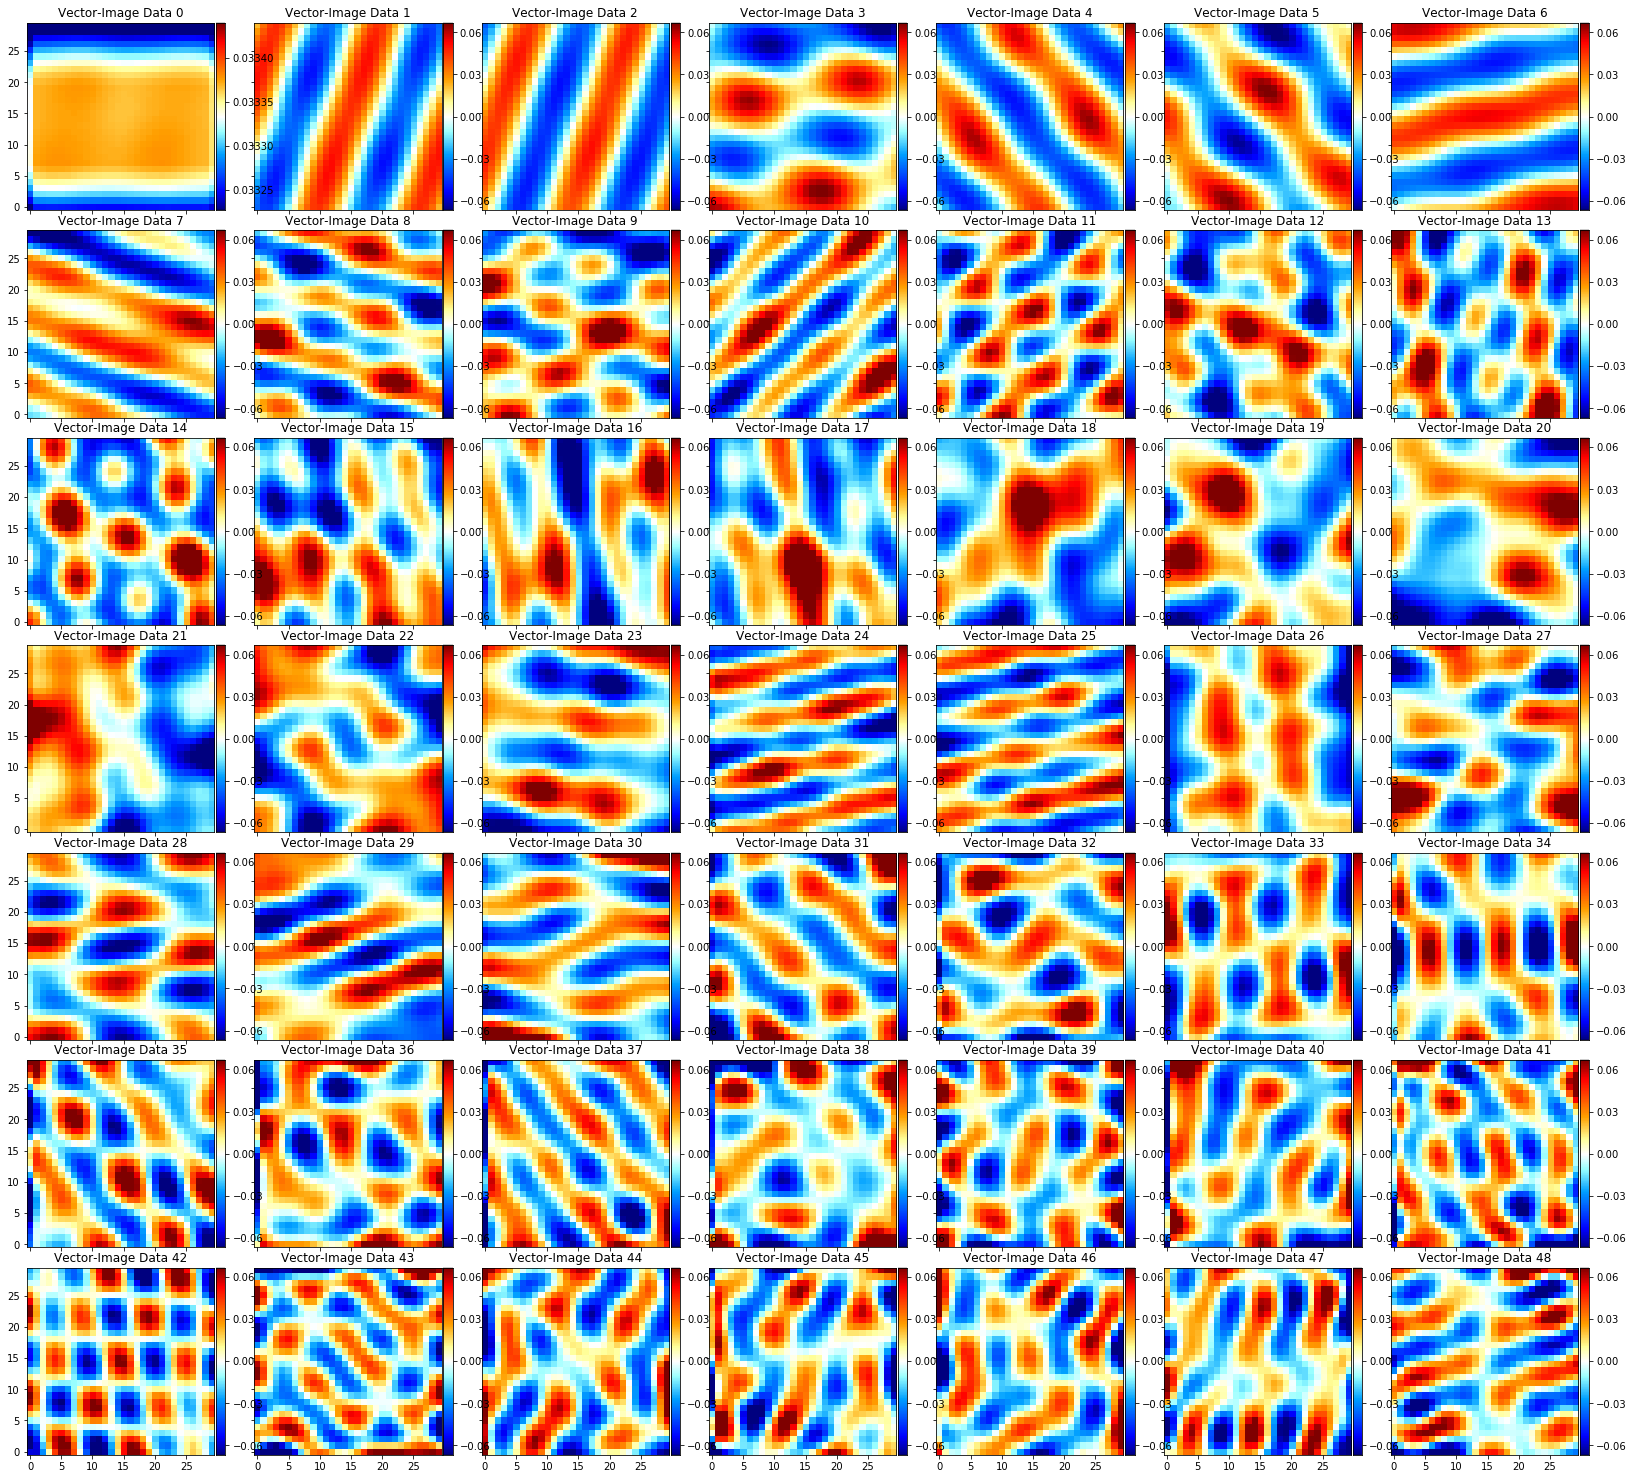

In [16]:
# Plot eigenvectors
for field in V_map_stack.dtype.names:
    fig_V, ax_V = px.plot_utils.plot_map_stack(V_map_stack[:,:,:][field], heading='', title='Vector-'+field, num_comps=plot_comps, 
                                               color_bar_mode='each', cmap=px.plot_utils.cmap_jet_white_center())   

#### U (Eigenvalues or loading maps):
The plot below shows the spatial distribution of each component

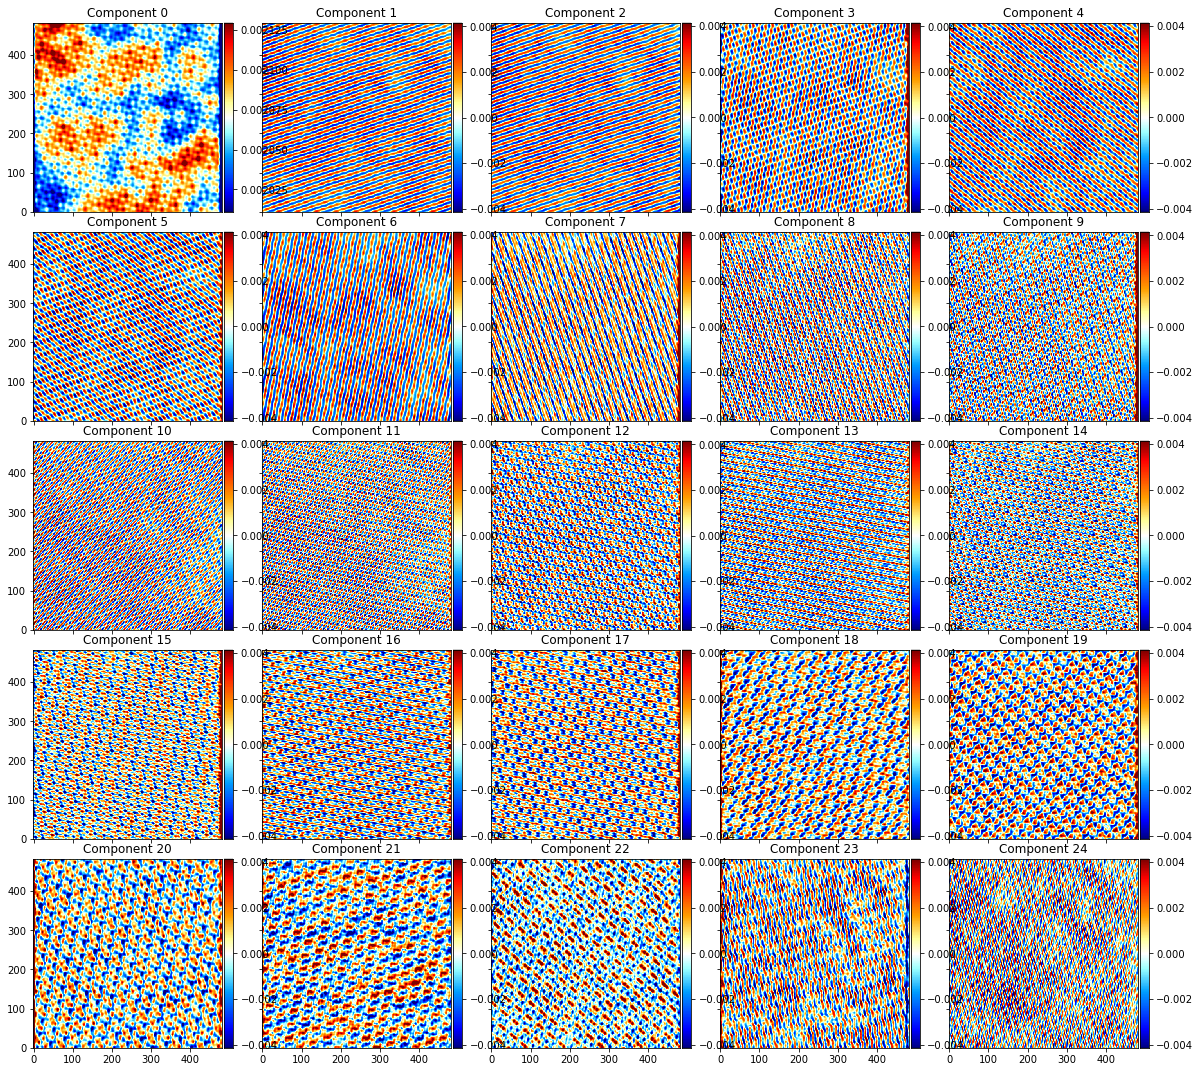

In [17]:
# Plot loading maps
fig_U, ax_U = px.plot_utils.plot_map_stack(U_map_stack[:,:,:25], heading='', title='Component', num_comps=plot_comps, 
                                           color_bar_mode='each', cmap=px.plot_utils.cmap_jet_white_center())
# keeping the axis direction consistent with plots above
# for axis in fig_U.axes:
#     axis.invert_yaxis()

## Reconstruct image (while removing noise)
Since SVD is just a decomposition technique, it is possible to reconstruct the data with U, S, V matrices. 

It is also possible to reconstruct a version of the data with a set of components. 

Thus, by reconstructing with the first few components, we can remove the statistical noise in the data. 

##### The key is to select the appropriate (number of) components to reconstruct the image without the noise

In [18]:
# Rebuild the image with up to a 100 components:
clean_components = range(64)
num_components=len(clean_components)

do_clean = True
try:
    h5_clean_image = h5_wins.parent['Image_Windows-SVD_000/Cleaned_Image_000/Cleaned_Image']
    
    new_clean = px.processing.svd_utils._get_component_slice(clean_components)
    if clean_components is None:
        new_clean = 'None-None'
    elif isinstance(old_clean, slice):
        new_clean = '{}-{}'.format(new_clean.start, new_clean.stop)
    
    if h5_clean_image.parent.attrs['components_used']==new_clean:
        print( 'Existing clean image found.  No need to rebuild.')
        do_clean = False
    else:
        print( 'Existing clean image found, but used different components.  Rebuild needed.')
except:
    print( 'Could not load clean image.  Rebuild needed.')

if do_clean:
    t0 = time()
    #h5_clean_image = iw.clean_and_build_batch(h5_win=h5_wins, components=clean_components)
    h5_clean_image = iw.clean_and_build_separate_components(h5_win=h5_wins, components=clean_components)
    print( 'Cleaning and rebuilding image took {} seconds.'.format(round(time()-t0, 2)))

image_vec_components = h5_clean_image[()]

# summing over the components:
for comp_ind in range(1, h5_clean_image.shape[1]):
    image_vec_components[:, comp_ind] = np.sum(h5_clean_image[:, :comp_ind+1], axis=1)
    
# converting to 3D:
image_components = np.reshape(image_vec_components, [num_x, num_y, -1])

# calculating the removed noise:
noise_components = image_components - np.reshape(np.tile(h5_raw[()], [1, h5_clean_image.shape[1]]), image_components.shape)

# defining a helper function to get the FFTs of a stack of images
def get_fft_stack(image_stack):
    blackman_window_rows = np.blackman(image_stack.shape[0])
    blackman_window_cols = np.blackman(image_stack.shape[1])
    fft_stack = np.zeros(image_stack.shape, dtype=np.float)
    for image_ind in range(image_stack.shape[2]):
        layer = image_stack[:, :, image_ind]
        windowed = blackman_window_rows[:, np.newaxis] * layer * blackman_window_cols[np.newaxis, :]
        fft_stack[:, :, image_ind] = np.abs(np.fft.fftshift(np.fft.fft2(windowed, axes=(0,1)), axes=(0,1)))
    return fft_stack

# get the FFT of the cleaned image and the removed noise:
fft_image_components = get_fft_stack(image_components)
fft_noise_components = get_fft_stack(noise_components)

Could not load clean image.  Rebuild needed.
Cleaning the image by removing unwanted components.
Reconstructing in batches of 4549 windows.
Reconstructing Image...0.0% -- step # 0
Reconstructing Image...10.0% -- step # 23329
Reconstructing Image...20.0% -- step # 46658
Reconstructing Image...30.0% -- step # 69987
Reconstructing Image...40.0% -- step # 93316
Reconstructing Image...50.0% -- step # 116645
Reconstructing Image...60.0% -- step # 139974
Reconstructing Image...70.0% -- step # 163303
Reconstructing Image...80.0% -- step # 186632
Reconstructing Image...90.0% -- step # 209961
Cleaning and rebuilding image took 86.99 seconds.


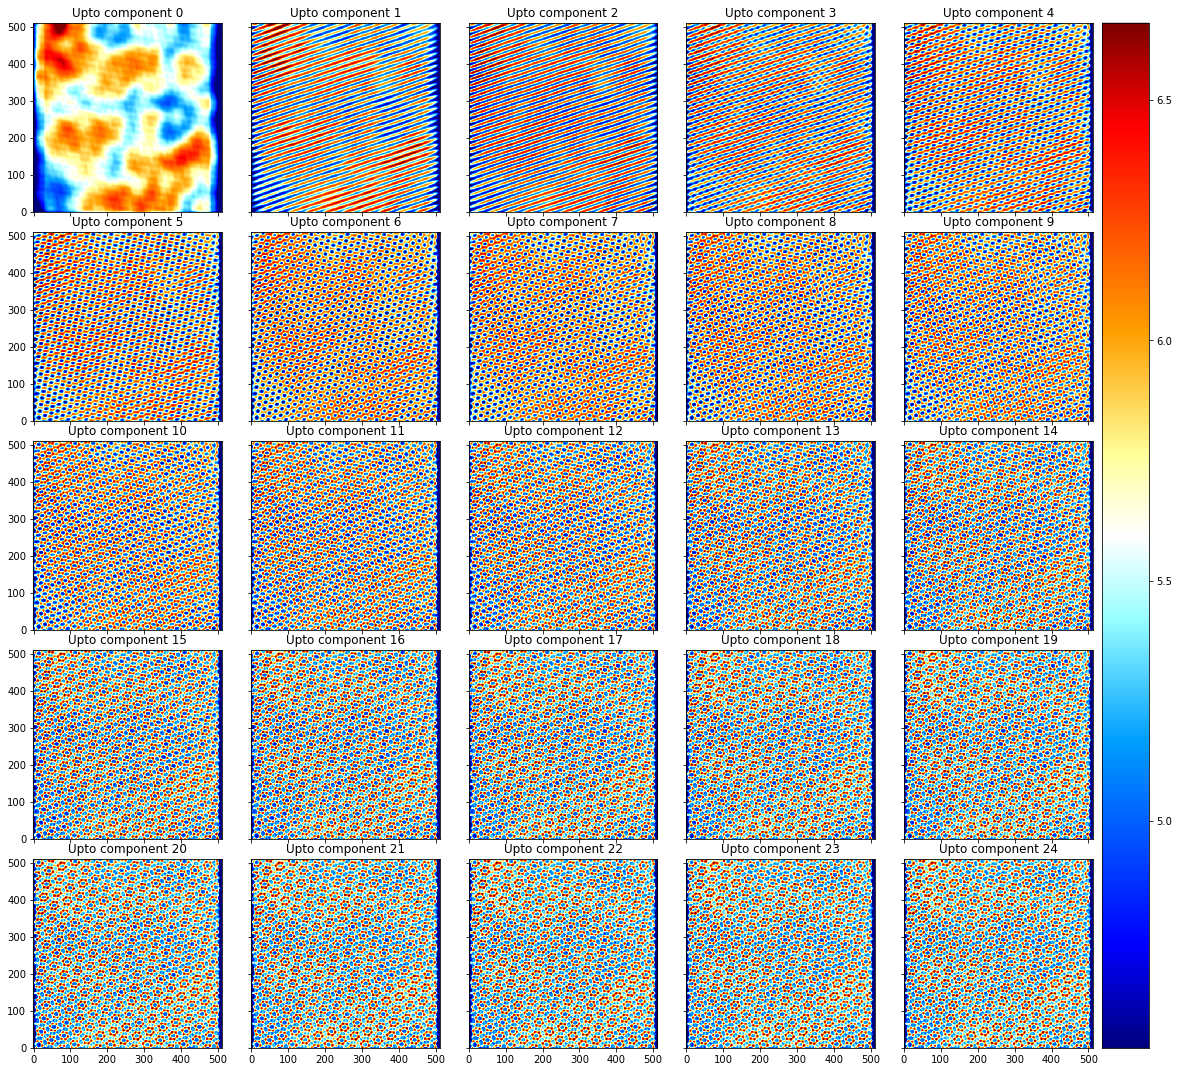

In [19]:
fig_U, ax_U = px.plot_utils.plot_map_stack(image_components[:,:,:25], heading='', evenly_spaced=False,
                                           title='Upto component', num_comps=plot_comps, color_bar_mode='single', 
                                           cmap=px.plot_utils.cmap_jet_white_center())
# keeping the axis direction consistent with plots above
# for axis in ax_U:
#     axis.invert_yaxis()

## Reconstruct the image with the first N components

slide the bar to pick the the number of components such that the noise is removed while maintaining the integrity of the image

<function __main__.move_comp_line>

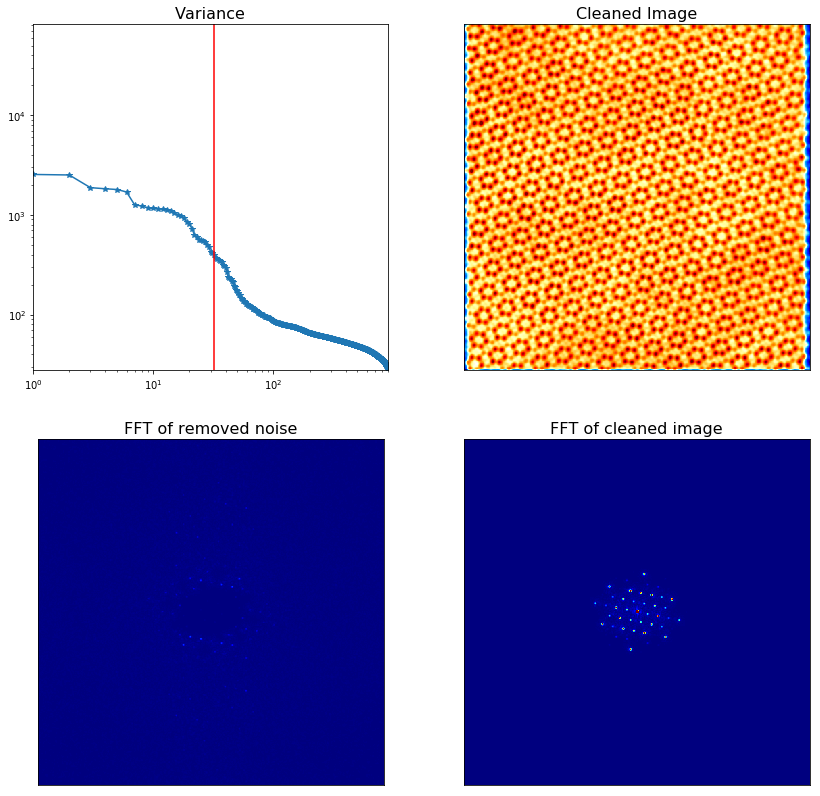

In [20]:
num_comps = min(16, image_components.shape[2])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axes.flat[0].loglog(h5_S[()], '*-')
axes.flat[0].set_xlim(left=1, right=h5_S[()].size)
axes.flat[0].set_ylim(bottom=np.min(h5_S[()]), top=np.max(h5_S[()]))
axes.flat[0].set_title('Variance', fontsize=16)
vert_line = axes.flat[0].axvline(x=num_comps, color='r')
clean_image_mat = image_components[:, :, num_comps]
img_clean = axes.flat[1].imshow(clean_image_mat, cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
axes.flat[1].get_yaxis().set_visible(False)
axes.flat[1].get_xaxis().set_visible(False)
axes.flat[1].set_title('Cleaned Image', fontsize=16)
fft_std_dev =  np.max(np.std(fft_image_components[:, :, num_comps]))
img_noise_fft = axes.flat[2].imshow(fft_noise_components[:, :, num_comps], cmap=plt.cm.jet,
                                    vmin=0, vmax=4*fft_std_dev, origin='lower')
axes.flat[2].get_yaxis().set_visible(False)
axes.flat[2].get_xaxis().set_visible(False)
axes.flat[2].set_title('FFT of removed noise', fontsize=16)
img_clean_fft = axes.flat[3].imshow(fft_image_components[:, :, num_comps], cmap=plt.cm.jet,
                                    vmin=0, vmax=4*fft_std_dev, origin='lower')
axes.flat[3].set_title('FFT of cleaned image', fontsize=16)
axes.flat[3].get_yaxis().set_visible(False)
axes.flat[3].get_xaxis().set_visible(False)

def move_comp_line(num_comps):
    vert_line.set_xdata((num_comps, num_comps))
    clean_image_mat = image_components[:, :, num_comps]
    img_clean.set_data(clean_image_mat)
    img_noise_fft.set_data(fft_noise_components[:, :, num_comps])
    img_clean_fft.set_data(fft_image_components[:, :, num_comps])
    clean_components = range(num_comps)
    display(fig)
    
widgets.interact(move_comp_line, num_comps=(1, image_components.shape[2]-1, 1))

# Atom Finding
We will attempt to find the positions and the identities of atoms in the image now

## Perform clustering on the dataset
Clustering divides data into k clusters such that the variance within each cluster is minimized.<br>
Here, we will be performing k-means clustering on a set of components in the U matrix from SVD.<br>
We want a large enough number of clusters so that K-means identifies fine nuances in the data. At the same time, we want to minimize computational time by reducing the number of clusters. We recommend 32 - 64 clusters.

Could not load Clustering results.
Performing clustering on /Measurement_000/Channel_000/Raw_Data-Windowing_001/Image_Windows-SVD_000/U.
Calculated the Mean Response of each cluster.
Writing clustering results to file.
kMeans took 78.18 seconds.
Clustering results in /Measurement_000/Channel_000/Raw_Data-Windowing_001/Image_Windows-SVD_000/U-Cluster_000.


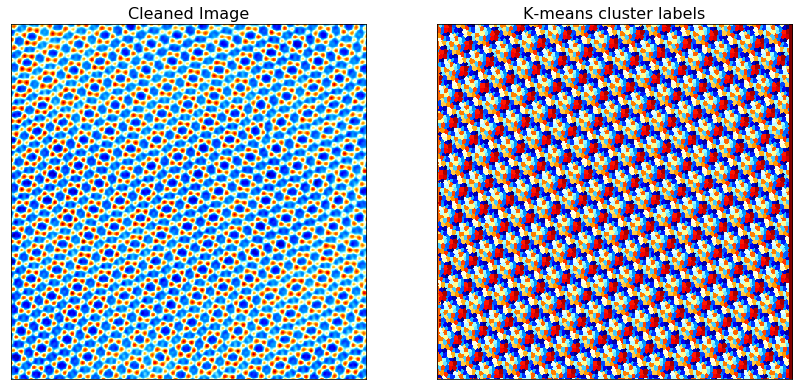

In [21]:
clean_components = range(28)
num_clusters = 32

# Check for existing Clustering results
estimator = px.Cluster(h5_U, 'KMeans', num_comps=clean_components, n_clusters=num_clusters)
do_cluster = False

# See if there are existing cluster results
try:
    h5_kmeans = h5_svd['U-Cluster_000']
    print( 'Clustering results loaded.  Will now check parameters')
except:
    print( 'Could not load Clustering results.')
    do_cluster = True

# Check that the same components are used
if not do_cluster:
    new_clean = estimator.data_slice[1]
    if isinstance(new_clean, np.ndarray):
        new_clean = new_clean.tolist()
    else:
        new_clean = range(new_clean.start, new_clean.stop, new_clean.step)
    
    if all(h5_kmeans.attrs['components_used']==new_clean):
        print( 'Clustering results used the same components as those requested.')
    else:
        do_cluster = True
        print( 'Clustering results used the different components from those requested.')

# Check that the same number of clusters were used
if not do_cluster:
    old_clusters = len(np.unique(h5_kmeans['Cluster_Indices']))
    
    if old_clusters==num_clusters:
        print( 'Clustering results used the same number of clusters as requested.')
    else:
        do_cluster = True
        print( 'Clustering results used a different number of clusters from those requested.')

# Perform k-means clustering on the U matrix now using the list of components only if needed:
if do_cluster:
    t0 = time()
    h5_kmeans = estimator.do_cluster()
    print( 'kMeans took {} seconds.'.format(round(time()-t0, 2)))
else:
    print( 'Using existing results.')

print( 'Clustering results in {}.'.format(h5_kmeans.name))

half_wind = int(win_size*0.5)
# generate a cropped image that was effectively the area that was used for pattern searching
# Need to get the math righ on the counting
cropped_clean_image = clean_image_mat[half_wind:-half_wind + 1, half_wind:-half_wind + 1]

# Plot cluster results Get the labels dataset
labels_mat = np.reshape(h5_kmeans['Labels'][()], [num_rows, num_cols])

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes[0].imshow(cropped_clean_image,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
axes[0].set_title('Cleaned Image', fontsize=16)
axes[1].imshow(labels_mat, aspect=1, interpolation='none',cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
axes[1].set_title('K-means cluster labels', fontsize=16);
for axis in axes:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

#### Visualize the hierarchical clustering
The vertical length of the branches indicates the relative separation between neighboring clusters.

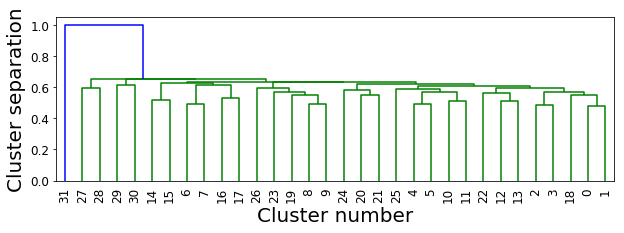

In [22]:
# Plot dendrogram here
#Get the distrance between cluster means 
distance_mat = pdist(h5_kmeans['Mean_Response'][()]) 
 
#get hierachical pairings of clusters 
linkage_pairing = linkage(distance_mat,'weighted') 

# Normalize the pairwise distance with the maximum distance
linkage_pairing[:,2] = linkage_pairing[:,2]/max(linkage_pairing[:,2]) 

# Visualize dendrogram
fig = plt.figure(figsize=(10,3)) 
retval = dendrogram(linkage_pairing, count_sort=True, 
           distance_sort=True, leaf_rotation=90) 
#fig.axes[0].set_title('Dendrogram') 
fig.axes[0].set_xlabel('Cluster number', fontsize=20) 
fig.axes[0].set_ylabel('Cluster separation', fontsize=20)
px.plot_utils.set_tick_font_size(fig.axes[0], 12)

## Identifiying the principal patterns
Here, we will interactively identify N windows, each centered on a distinct class / kind of atom.

Use the coarse and fine positions sliders to center the window onto target atoms. Click the "Set as motif" button to add this window to the list of patterns we will search for in the next step. Avoid duplicates.

/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  import sys


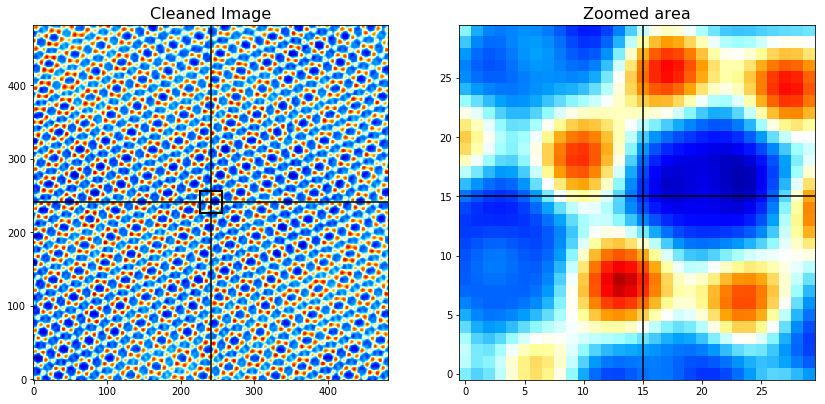

Setting motif with coordinates (261, 251)


In [23]:
motif_win_size = win_size
half_wind = int(motif_win_size*0.5)

current_center = [int(0.5*cropped_clean_image.shape[0]), int(0.5*cropped_clean_image.shape[1])]

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes[0].hold(True)
axes[0].imshow(cropped_clean_image,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
axes[0].set_title('Cleaned Image', fontsize=16)
main_vert_line = axes[0].axvline(x=current_center[1], color='k')
main_hor_line = axes[0].axhline(y=current_center[0], color='k')
motif_box = axes[0].add_patch(patches.Rectangle((current_center[1] - half_wind, current_center[0] - half_wind),
                                          motif_win_size, motif_win_size, fill=False,
                                         color='black', linewidth=2))
indices = (slice(current_center[0] - half_wind, current_center[0] + half_wind), 
           slice(current_center[1] - half_wind, current_center[1] + half_wind))
img_zoom = axes[1].imshow(cropped_clean_image[indices],cmap=px.plot_utils.cmap_jet_white_center(), 
               vmax=np.max(cropped_clean_image), vmin=np.min(cropped_clean_image), origin='lower')
axes[1].axvline(x=half_wind, color='k')
axes[1].axhline(y=half_wind, color='k')
axes[1].set_title('Zoomed area', fontsize=16)

add_motif_button = widgets.Button(description="Set as motif")
display(add_motif_button)

def move_zoom_box(coarse_row, coarse_col, fine_row, fine_col):
    row = coarse_row + fine_row
    col = coarse_col + fine_col
    main_vert_line.set_xdata((col, col))
    main_hor_line.set_ydata((row, row))
    current_center[0] = row
    current_center[1] = col
    motif_box.set_x(col - half_wind)
    motif_box.set_y(row - half_wind)
    indices = (slice(row - half_wind, row + half_wind), 
               slice(col - half_wind, col + half_wind))
    img_zoom.set_data(cropped_clean_image[indices])
    img_zoom.set_clim(vmin=np.min(cropped_clean_image), vmax=np.max(cropped_clean_image))
    display(fig)
    
motif_win_centers = list()

def add_motif(butt):
    print("Setting motif with coordinates ({}, {})".format(current_center[0], current_center[1]))
    axes[0].add_patch(patches.Rectangle((current_center[1] - int(0.5*motif_win_size), 
                                           current_center[0] - int(0.5*motif_win_size)),
                                          motif_win_size, motif_win_size, fill=False,
                                         color='black', linewidth=2))
    motif_win_centers.append((current_center[0], current_center[1]))
    # print(motif_win_centers)
    
widgets.interact(move_zoom_box, coarse_row=(motif_win_size, cropped_clean_image.shape[0] - motif_win_size, 1), 
                 coarse_col=(motif_win_size, cropped_clean_image.shape[1] - motif_win_size, 1),
                 fine_row=(-half_wind,half_wind,1), fine_col=(-half_wind,half_wind,1));
add_motif_button.on_click(add_motif)

### Visualize the motifs that were selected above

Coordinates of the centers of the chosen motifs:
[(261, 251)]


/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


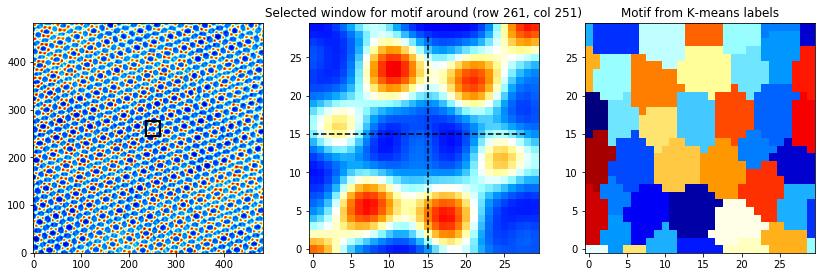

In [25]:
# select motifs from the cluster labels using the component list:
# motif_win_centers = [(135, 128), (106, 125), (62, 204), (33, 206)]
print('Coordinates of the centers of the chosen motifs:')
print(motif_win_centers)
motif_win_size = win_size
half_wind = int(motif_win_size*0.5)

# Effectively, we end up cropping the image again by the window size while matching patterns so:
double_cropped_image = cropped_clean_image[half_wind:-half_wind, half_wind:-half_wind]

# motif_win_size = 15  # Perhaps the motif should be smaller than the original window
num_motifs = len(motif_win_centers)
motifs = list()
fig, axes = plt.subplots(ncols=3, nrows=num_motifs, figsize=(14,6 * num_motifs))

for window_center, ax_row in zip(motif_win_centers, np.atleast_2d(axes)):
    indices = (slice(window_center[0] - half_wind, window_center[0] + half_wind), 
               slice(window_center[1] - half_wind, window_center[1] + half_wind))
    motifs.append(labels_mat[indices])
    
    ax_row[0].hold(True)
    ax_row[0].imshow(cropped_clean_image, interpolation='none',cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
    ax_row[0].add_patch(patches.Rectangle((window_center[1] - int(0.5*motif_win_size), 
                                           window_center[0] - int(0.5*motif_win_size)),
                                          motif_win_size, motif_win_size, fill=False,
                                         color='black', linewidth=2))
    ax_row[0].hold(False)
    ax_row[1].hold(True)
    ax_row[1].imshow(cropped_clean_image[indices], interpolation='none',cmap=px.plot_utils.cmap_jet_white_center(),
                     vmax=np.max(cropped_clean_image), vmin=np.min(cropped_clean_image), origin='lower')
    ax_row[1].plot([0, motif_win_size-2],[int(0.5*motif_win_size), int(0.5*motif_win_size)], 'k--')
    ax_row[1].plot([int(0.5*motif_win_size), int(0.5*motif_win_size)], [0, motif_win_size-2], 'k--')
    # ax_row[1].axis('tight')
    ax_row[1].set_title('Selected window for motif around (row {}, col {})'.format(window_center[0], window_center[1]))
    ax_row[1].hold(False)
    ax_row[2].imshow(labels_mat[indices], interpolation='none',cmap=px.plot_utils.cmap_jet_white_center(),
                     vmax=num_clusters-1, vmin=0, origin='lower')
    ax_row[2].set_title('Motif from K-means labels');

## Calculate matching scores for each motif
We do this by sliding each motif across the cluster labels image to find how the motif matches with the image

In [27]:
motif_match_coeffs = list()

for motif_mat in motifs:
    
    match_mat = np.zeros(shape=(num_rows-motif_win_size, num_cols-motif_win_size))
    for row_count, row_pos in enumerate(range(half_wind, num_rows - half_wind - 1, 1)):
        for col_count, col_pos in enumerate(range(half_wind, num_cols - half_wind - 1, 1)):
            local_cluster_mat = labels_mat[row_pos-half_wind : row_pos+half_wind, 
                                           col_pos-half_wind : col_pos+half_wind]
            match_mat[row_count, col_count] = np.sum(local_cluster_mat == motif_mat)
    # Normalize the dataset:
    match_mat = match_mat/np.max(match_mat)
    
    motif_match_coeffs.append(match_mat)

## Visualize the matching scores
Note: If a pair of motifs are always matching for the same set of atoms, perhaps this may be a duplicate motif. Alternatively, if these motifs do indeed identify distinct classes of atoms, consider:
* clustering again with a different set of SVD components
* increasing the number of clusters
* Choosing a different fft mode ('data+fft' for better identify subtle but important variations) before performing windowing on the data

/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/ba8/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ba8/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


TypeError: 'LinearSegmentedColormap' object does not support indexing

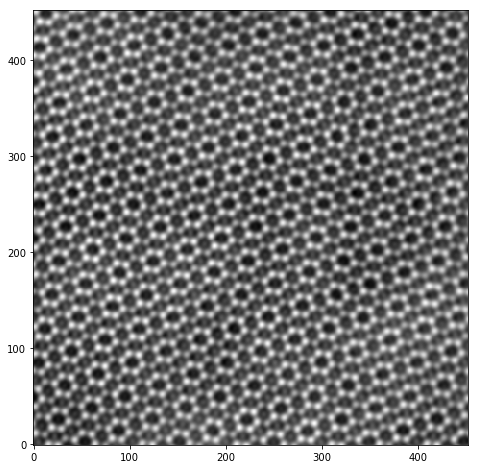

In [28]:
show_legend = True

base_color_map = plt.cm.jet
fig = plt.figure(figsize=(8, 8))
plt.hold(True)
im = plt.imshow(double_cropped_image, cmap="gray", origin='lower')
#fig.suptitle('Pattern matching coefficients', fontsize=16)

if num_motifs > 1:
    motif_colors = [base_color_map(int(255 * motif_ind / (num_motifs - 1))) for motif_ind in range(num_motifs)]
else:
    motif_colors = [base_color_map[0]]
handles = list()
for motif_ind, current_solid_color, match_mat in zip(range(num_motifs), motif_colors, motif_match_coeffs):
    my_cmap = px.plot_utils.make_linear_alpha_cmap('fdfd', current_solid_color, 1)
    im = plt.imshow(match_mat, cmap=my_cmap, origin='lower');
    current_solid_color = list(current_solid_color)
    current_solid_color[3] = 0.5 # maximum alpha value
    handles.append(patches.Patch(color=current_solid_color, label='Motif {}'.format(motif_ind)))
if show_legend:
    plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=14)
plt.hold(False)
axis = fig.get_axes()[0]
axis.set_title('Pattern matching scores', fontsize=22)
axis.set_xticklabels([])
axis.set_yticklabels([])
axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)


## Convert matching scores to binary
We do this by thresholding the matching scores such that a score beyond the threshold is set to 1 and all other values are set to 0. 

The goal is to set the thresholds such that we avoid overlaps between two clusters and also shrink the blobs such that they are only centered over a single atom wherever possible.

Use the sliders below to interactively set the threshold values

/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  import sys
/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ba8/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ba8/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


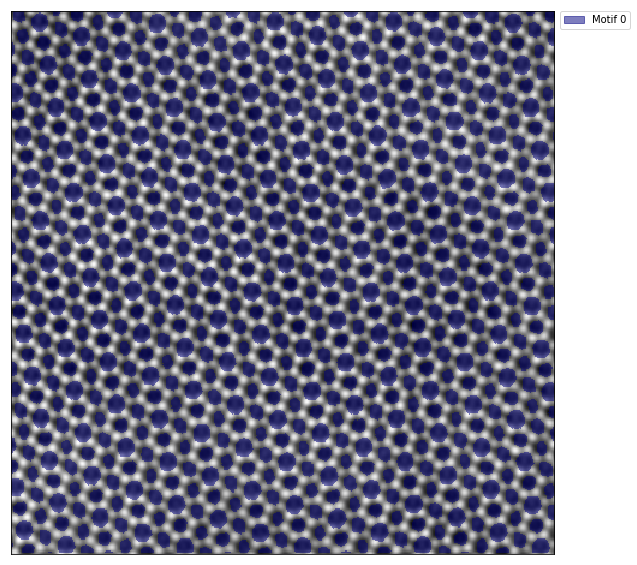

In [29]:
thresholds = [0.25 for x in range(num_motifs)]
thresholded_maps = list()
motif_imgs = list()

base_color_map = plt.cm.jet
fig, axis = plt.subplots(figsize=(10, 10))
axis.hold(True)
axis.imshow(double_cropped_image, cmap="gray")
handles = list()
if num_motifs > 1:
    motif_colors = [base_color_map(int(255 * motif_ind / (num_motifs - 1))) for motif_ind in range(num_motifs)]
else:
    motif_colors = [base_color_map(0)]

for motif_ind, match_mat, t_hold, current_solid_color in zip(range(num_motifs), motif_match_coeffs, 
                                                             thresholds, motif_colors):
    my_cmap = px.plot_utils.make_linear_alpha_cmap('fdfd', current_solid_color, 1, max_alpha=0.5)
    bin_map = np.where(match_mat > t_hold, 
                       np.ones(shape=match_mat.shape, dtype=np.uint8),
                       np.zeros(shape=match_mat.shape, dtype=np.uint8))
    thresholded_maps.append(bin_map)
    motif_imgs.append(axis.imshow(bin_map, interpolation='none', cmap=my_cmap))
    current_solid_color = list(current_solid_color)
    current_solid_color[3] = 0.5
    handles.append(patches.Patch(color=current_solid_color,label='Motif {}'.format(motif_ind)))

axis.set_xticklabels([])
axis.set_yticklabels([])
axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)
plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.hold(False)

def threshold_images(thresholds):
    # thresholded_maps = list()
    # empty the thresholded maps:
    del thresholded_maps[:]
    for motif_ind, match_mat, t_hold, current_solid_color in zip(range(num_motifs), motif_match_coeffs, thresholds, motif_colors):
        my_cmap = px.plot_utils.make_linear_alpha_cmap('fdfd', current_solid_color, 1, max_alpha=0.5)
        bin_map = np.where(match_mat > t_hold, 
                           np.ones(shape=match_mat.shape, dtype=np.uint8),
                           np.zeros(shape=match_mat.shape, dtype=np.uint8))
        thresholded_maps.append(bin_map)
    
def interaction_unpacker(**kwargs):
    #threshs = range(num_motifs)
    for motif_ind in range(num_motifs):
        thresholds[motif_ind] = kwargs['Motif ' + str(motif_ind)]
    threshold_images(thresholds)
    for img_handle, th_image in zip(motif_imgs, thresholded_maps):
        img_handle.set_data(th_image)
    display(fig)
    
temp_thresh = dict()
for motif_ind in range(num_motifs):
    temp_thresh['Motif ' + str(motif_ind)] = (0,1,0.025)
widgets.interact(interaction_unpacker, **temp_thresh);

## Find the atom centers from the binary maps
The centers of the atoms will be inferred from the centroid of each of the blobs.

In [30]:
print(thresholds)
# Uncomment to set thresholds manually
# thresholds = [0.075, 0.075, 0.075, 0.075]
# find the centers of the patches in the binarized images above
atom_labels = list()
for thresh_map in thresholded_maps:
    labled_atoms = measure.label(thresh_map, background=0)
    map_props = measure.regionprops(labled_atoms)
    atom_centroids = np.zeros(shape=(len(map_props),2))
    for atom_ind, atom in enumerate(map_props):
        atom_centroids[atom_ind] = np.array(atom.centroid)
    atom_labels.append(atom_centroids)

[0.0]


## Visualize the atom positions

/Users/ba8/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


ZeroDivisionError: division by zero

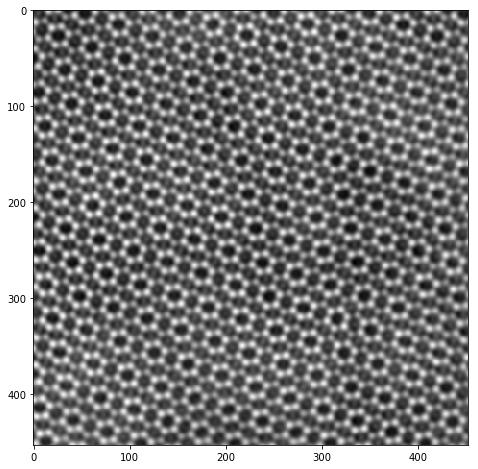

In [31]:
# overlay atom positions on original image
fig, axis = plt.subplots(figsize=(8,8))
axis.hold(True)
col_map = plt.cm.jet
axis.imshow(double_cropped_image, interpolation='none',cmap="gray")
legend_handles = list()
for atom_type_ind, atom_centroids in enumerate(atom_labels):    
    axis.scatter(atom_centroids[:,1], atom_centroids[:,0], color=col_map(int(255 * atom_type_ind / (num_motifs-1))),
                 label='Motif {}'.format(atom_type_ind), s=30)
axis.set_xlim(0, double_cropped_image.shape[0])
axis.set_ylim(0, double_cropped_image.shape[1]);
axis.invert_yaxis()

axis.set_xticklabels([])
axis.set_yticklabels([])
axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
axis.set_title('Atom Positions', fontsize=22)

fig.tight_layout()

### Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [ ]:
file_handle.close()